In [1]:
%%time
import matplotlib as plt
%matplotlib inline
# Import libraries
import pystan
import pandas as pd
import numpy as np
from pystan import StanModel

import pickle

# The Stan model as a string.
model_string = """
# Underlying causal model:
# - `device_noise` is background variable
# Structural equations are:
# 1. observed_temperature = temperature + device_noise

data {
  real d_observed_temperature;   # observation
  real hat_observed_temperature; # intervention
  # intervention-flag is explicitly part of input, as a hyperparameter
  int<lower=0,upper=2> hyper_type_observed_temperature; # `0` is nothing
                                                        # `1` is intervention
                                                        # `2` is observation
}

transformed data{
}

parameters {
  # generally, only "background" variables
  # go to `parameters` block, because it is more
  # natural to reexpress causal relation to fit
  # Stan's rule by putting "foreground" factors on
  # the left
  
  real u_device_noise;
  real<lower=-90,upper=50> u_temperature;
}

transformed parameters { 
  real<lower=-90,upper=50> temperature;
  real<lower=-90,upper=50> device_noise;
  real<lower=-90,upper=50> observed_temperature;
  
  device_noise = u_device_noise;
  temperature = u_temperature;
  observed_temperature = temperature + device_noise;
  
  if (hyper_type_observed_temperature == 1) { 
      # if we intervene, then causal model is mutilated
      
      observed_temperature = hat_observed_temperature;    
  }
  else if (hyper_type_observed_temperature == 2) {
      # If we do not intervene, then causal relation stays in place
      # but we have to reexpress it to fit Stan's requirements
      # about assignments: the left-hand side should be `transformed parameter`.
      # (
      #  see https://groups.google.com/forum/#!topic/stan-users/CG3xM1TCacs:
      #  "You can only define (i.e., assign) variables in the block in which they were declared."
      # )
      # This reexpression doesn't mutilate the causal model,
      # at least not in this simple case.
      
      observed_temperature = d_observed_temperature; # we condition here, not intervene
      temperature = observed_temperature - device_noise;
      
      # TODO: figure out how to handle models where `temperature` is Pa to more than
      #       one variable (say, two termometers) - and still maintain flexibility
      #       of expressing model mutilation (erasing functional statements) using
      #       hyperparameters (without recompiling the model).
      
      # TODO: figure out how to incorporate prior for `temperature`
  }
  else {
  
  }
}

model {  
  u_device_noise ~ normal(0,2);
  u_temperature ~ normal(20,u_device_noise);
}
generated quantities {
}
"""

sm = StanModel(model_code = model_string)

with open('causality_stan_sm.pkl', 'wb') as f:
    pickle.dump(sm, f)

/Users/dimitry/anaconda/lib/python3.5/site-packages/numexpr/cpuinfo.py:76: UserWarning: [Errno 2] No such file or directory: 'sysctl'
  stacklevel=stacklevel + 1):
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2bc2f718718feca888698d9d8ff005d4 NOW.


CPU times: user 3.8 s, sys: 818 ms, total: 4.62 s
Wall time: 1min 18s


Inference for Stan model: anon_model_2bc2f718718feca888698d9d8ff005d4.
20 chains, each with iter=40000; warmup=20000; thin=1; 
post-warmup draws per chain=20000, total post-warmup draws=400000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
u_device_noise         1.66  9.2e-3   1.19   0.17   0.71   1.41   2.34   4.51  16760    1.0
u_temperature         19.99  7.1e-3   2.03  15.58  19.22  19.99  20.77   24.4  81724    1.0
temperature           38.34  9.2e-3   1.19  35.49  37.66  38.59  39.29  39.83  16760    1.0
device_noise           1.66  9.2e-3   1.19   0.17   0.71   1.41   2.34   4.51  16760    1.0
observed_temperature   40.0     0.0    0.0   40.0   40.0   40.0   40.0   40.0 400000    nan
lp__                   1.94    0.01   1.63   -1.8   1.03    2.1   3.04   4.69  13554    1.0

Samples were drawn using NUTS at Tue Nov 21 14:44:12 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scal

LinAlgError: singular matrix

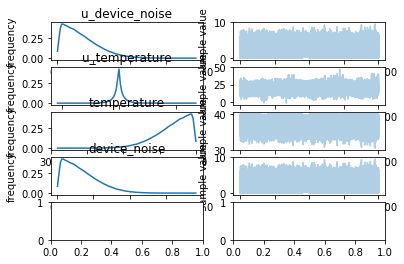

In [3]:
%%time
import pickle
with open('causality_stan_sm.pkl', 'rb') as f:
    sm = pickle.load(f)

# Compiling and producing posterior samples from the model.
stan_samples = sm.sampling(data = {
                                'hyper_type_observed_temperature': 2,
                                'd_observed_temperature': 40,
                                'hat_observed_temperature': 0 # isn't used
                           },
                           seed=1,
                           chains=20,
                           iter=40000
                          )

# Plotting and summarizing the posterior distribution
print(stan_samples)
print(stan_samples.plot())

Inference for Stan model: anon_model_f1c1159118f190e69345e2b4aeb8a522.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
u_device_noise       6.4e-3    0.18   9.98 -19.64  -6.64   -0.1   6.61  19.53   3187    1.0
u_temperature        -19.44    0.69  40.25 -85.88 -54.88 -19.23  16.22  45.99   3374    1.0
temperature          -19.44    0.69  40.25 -85.88 -54.88 -19.23  16.22  45.99   3374    1.0
device_noise         6.4e-3    0.18   9.98 -19.64  -6.64   -0.1   6.61  19.53   3187    1.0
observed_temperature   30.0     0.0    0.0   30.0   30.0   30.0   30.0   30.0   4000    nan
lp__                   2.47    0.03   1.05  -0.24   2.04   2.76   3.23   3.53   1746    1.0

Samples were drawn using NUTS at Sat Sep  2 10:26:44 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale redu

LinAlgError: singular matrix

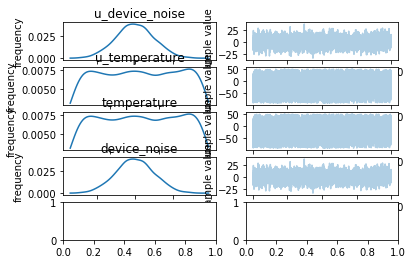

In [51]:
import pickle
with open('causality_stan_sm.pkl', 'rb') as f:
    sm = pickle.load(f)

stan_samples = sm.sampling(data = {
                                'hyper_type_observed_temperature': 1, # we just keep a needle with a finger
                                'hat_observed_temperature': 30,
                                'd_observed_temperature': 0 # not used
                           },
                           seed=1
                          )

print(stan_samples)
print(stan_samples.plot())